<a href="https://colab.research.google.com/github/Bhuvanachandhiran/conflict-early-warning-system/blob/main/conflict_early_warning_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas scikit-learn imbalanced-learn geopandas folium matplotlib

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import io
import requests
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import geopandas as gpd
import folium
from folium.plugins import HeatMap

In [ ]:
# Direct download URL for UCDP GED v25.1 CSV ZIP (from official site pattern)
url = 'https://ucdp.uu.se/downloads/ged/ged251-csv.zip'

# Download the ZIP
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# Print the names of all files in the zip archive to find the correct CSV filename
print("Files in the ZIP archive:")
for name in zip_file.namelist():
    print(name)

# Extract the CSV file (assuming the filename inside is 'ged251.csv')
csv_filename = 'GEDEvent_v25_1.csv'
with zip_file.open(csv_filename) as f:
    df = pd.read_csv(f, low_memory=False)

print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Files in the ZIP archive:
GEDEvent_v25_1.csv
Dataset loaded with 385918 rows and 49 columns.


,id,relid,year,active_year,code_status,type_of_violence,conflict_dset_id,conflict_new_id,conflict_name,dyad_dset_id,...,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,high,low,gwnoa,gwnob
0,244657,IRQ-2017-1-524-322,2017,True,Clear,1,259,259,Iraq: Government,524,...,2017-07-31 00:00:00.000,0,4,0,2,6,6,6,645,NaN
1,412700,IRQ-2021-1-524-145,2021,True,Clear,1,259,259,Iraq: Government,524,...,2021-08-26 00:00:00.000,13,1,141,28,183,184,171,645,NaN
2,413023,IRQ-2021-1-524-143,2021,True,Clear,1,259,259,Iraq: Government,524,...,2021-08-28 00:00:00.000,0,2,0,0,2,3,0,645,NaN
3,412909,IRQ-2021-1-524-144,2021,True,Clear,1,259,259,Iraq: Government,524,...,2021-08-29 00:00:00.000,0,0,10,0,10,10,9,645,NaN
4,132140,AFG-1989-1-411-2,1989,True,Clear,1,333,333,Afghanistan: Government,724,...,1989-01-13 00:00:00.000,6,0,0,0,6,6,6,700,NaN


In [ ]:
# Filter to Africa and years 2010-2024 for a manageable subset
africa_countries = ['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon',
                    'Central African Republic', 'Chad', 'Comoros', 'Congo', 'Democratic Republic of the Congo',
                    'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon',
                    'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Ivory Coast', 'Kenya', 'Lesotho',
                    'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco',
                    'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe', 'Senegal',
                    'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Tanzania',
                    'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe']

df_filtered = df[(df['country'].isin(africa_countries)) & (df['year'] >= 2010)]

print(f"Filtered dataset: {df_filtered.shape[0]} rows.")
df_filtered.describe()

Filtered dataset: 35229 rows.


,id,year,type_of_violence,conflict_dset_id,conflict_new_id,dyad_dset_id,dyad_new_id,side_a_dset_id,side_a_new_id,side_b_dset_id,...,event_clarity,date_prec,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,high,low,gwnob
count,35229.000000,35229.000000,35229.000000,35229.000000,35229.000000,35229.000000,35229.000000,35229.000000,35229.000000,35229.000000,...,35229.000000,35229.000000,35229.000000,35229.000000,35229.000000,35229.000000,35229.000000,35229.000000,35229.000000,28.000000
mean,312553.961793,2018.509580,1.720827,5118.461552,5597.262653,7460.864543,8246.554600,949.736524,949.736524,4879.266769,...,1.093332,1.353487,8.134832,3.796815,2.408584,1.784127,16.124358,19.187488,15.479804,621.607143
std,157912.290644,4.075066,0.884292,6014.097175,6232.945471,6796.004655,6872.302678,2033.957401,2033.957401,4144.642857,...,0.290902,0.791960,824.380060,145.694274,12.957204,17.826418,903.037274,789.655883,903.083313,17.953312
min,1925.000000,2010.000000,1.000000,57.000000,234.000000,57.000000,477.000000,3.000000,3.000000,97.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,530.000000
25%,214276.000000,2015.000000,1.000000,309.000000,353.000000,719.000000,938.000000,86.000000,86.000000,717.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,625.000000
50%,317171.000000,2019.000000,1.000000,416.000000,604.000000,5584.000000,10589.000000,97.000000,97.000000,5802.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,2.000000,625.000000
75%,450386.000000,2022.000000,3.000000,11347.000000,13639.000000,14677.000000,15108.000000,591.000000,591.000000,9999.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,7.000000,9.000000,6.000000,625.000000
max,571765.000000,2024.000000,3.000000,18302.000000,16472.000000,18302.000000,18302.000000,9249.000000,9249.000000,9999.000000,...,2.000000,5.000000,121848.000000,19874.000000,932.000000,1818.000000,121848.000000,121848.000000,121848.000000,625.000000


In [ ]:
# Aggregate by country and year
df_agg = df_filtered.groupby(['country', 'year']).agg({
    'best': 'sum',  # Total fatalities
    'id': 'count',  # Number of events, using the 'id' column
    'type_of_violence': lambda x: x.nunique(),  # Unique violence types
    'side_a': lambda x: x.nunique(),  # Unique actors A
    'side_b': lambda x: x.nunique(),  # Unique actors B
    'latitude': 'mean',  # Avg latitude (for geospatial)
    'longitude': 'mean'  # Avg longitude
}).rename(columns={
    'best': 'total_fatalities',
    'id': 'event_count', # Renamed 'id' to 'event_count'
    'type_of_violence': 'violence_types',
    'side_a': 'actors_a',
    'side_b': 'actors_b'
}).reset_index()

# Create lag features (previous year's values)
df_agg = df_agg.sort_values(['country', 'year'])
df_agg['prev_fatalities'] = df_agg.groupby('country')['total_fatalities'].shift(1)
df_agg['prev_event_count'] = df_agg.groupby('country')['event_count'].shift(1)
df_agg['prev_violence_types'] = df_agg.groupby('country')['violence_types'].shift(1)

# Fill NaNs for first year with 0
df_agg.fillna(0, inplace=True)

# Define target: Onset if total_fatalities >= 25 (simplified UCDP threshold for conflict)
df_agg['onset'] = (df_agg['total_fatalities'] >= 25).astype(int)

# Shift target to predict NEXT year's onset
df_agg['target_onset'] = df_agg.groupby('country')['onset'].shift(-1)
df_agg.dropna(subset=['target_onset'], inplace=True)  # Drop last year per country

print(df_agg.head())
print(f"Class distribution: {df_agg['target_onset'].value_counts(normalize=True)}")

   country  year  total_fatalities  event_count  violence_types  actors_a  \
0  Algeria  2010               252           92               2         2   
1  Algeria  2011               276          125               2         2   
2  Algeria  2012               264          124               2         2   
3  Algeria  2013               222           73               3         3   
4  Algeria  2014               111           43               1         1   

   actors_b   latitude  longitude  prev_fatalities  prev_event_count  \
0         2  36.066359   4.364946              0.0               0.0   
1         2  35.879504   4.253417            252.0              92.0   
2         3  35.851574   4.007789            276.0             125.0   
3         4  32.875359   3.630726            264.0             124.0   
4         2  35.165845   3.720189            222.0              73.0   

   prev_violence_types  onset  target_onset  
0                  0.0      1           1.0  
1           

In [ ]:
# Features (exclude non-predictive cols)
features = ['prev_fatalities', 'prev_event_count', 'prev_violence_types', 'actors_a', 'actors_b', 'latitude', 'longitude']
X = df_agg[features]
y = df_agg['target_onset']

# Train-test split (use time-based: train on 2010-2020, test on 2021-2024)
train_mask = df_agg['year'] <= 2020
X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[~train_mask], y[~train_mask]

# Handle imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Resampled train shape: {X_train_res.shape}")

Resampled train shape: (362, 7)


In [ ]:
# Define model and params
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Tune
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_res, y_train_res)

# Best model
best_rf = grid_search.best_estimator_
print(f"Best params: {grid_search.best_params_}")

Best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
# Predict
preds = best_rf.predict(X_test)
probs = best_rf.predict_proba(X_test)[:, 1]

# Reports
print(classification_report(y_test, preds))
print(f"ROC-AUC: {roc_auc_score(y_test, probs)}")

# Confusion matrix
cm = confusion_matrix(y_test, preds)
print("Confusion Matrix:\n", cm)

              precision    recall  f1-score   support

         0.0       0.68      0.60      0.64        25
         1.0       0.81      0.86      0.84        51

    accuracy                           0.78        76
   macro avg       0.75      0.73      0.74        76
weighted avg       0.77      0.78      0.77        76

ROC-AUC: 0.8964705882352941
Confusion Matrix:
 [[15 10]
 [ 7 44]]


               feature  importance
3             actors_a    0.201542
1     prev_event_count    0.194423
0      prev_fatalities    0.182354
4             actors_b    0.156188
6            longitude    0.105793
5             latitude    0.097369
2  prev_violence_types    0.062331


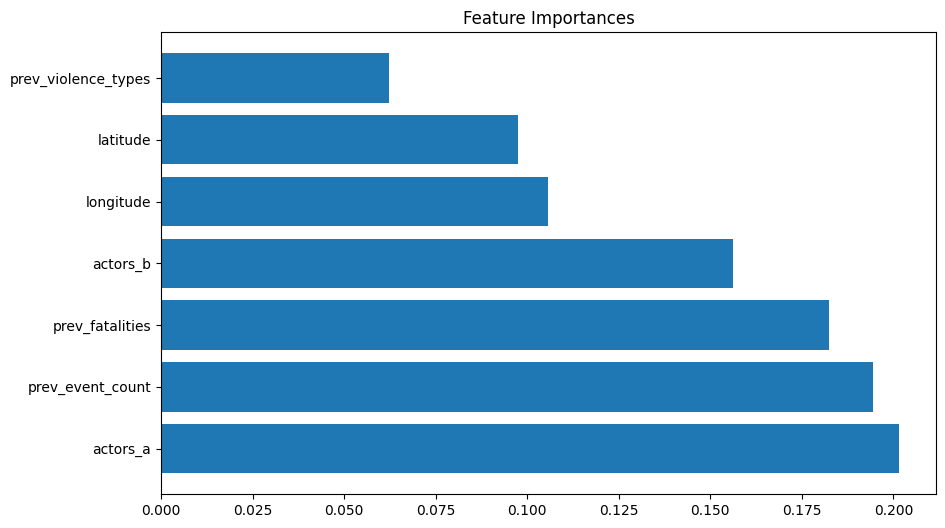

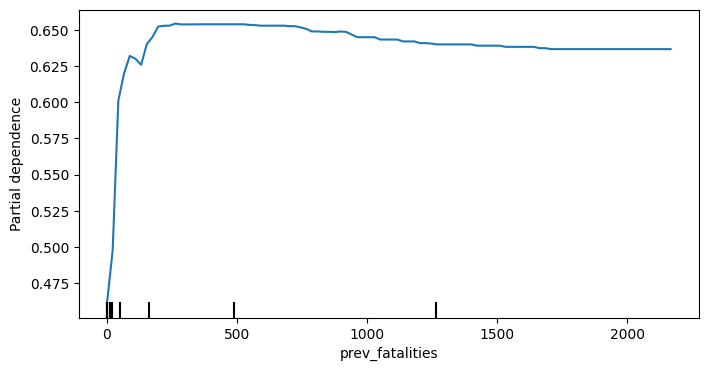

In [ ]:
# Feature importances
importances = pd.DataFrame({'feature': features, 'importance': best_rf.feature_importances_}).sort_values('importance', ascending=False)
print(importances)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importances['feature'], importances['importance'])
plt.title('Feature Importances')
plt.show()

# Partial dependence for top feature
fig, ax = plt.subplots(figsize=(8, 4))
PartialDependenceDisplay.from_estimator(best_rf, X_train_res, [0], ax=ax)  # Top feature index
plt.show()

In [ ]:
# Add predictions to test data
df_test = df_agg[~train_mask].copy()
df_test['predicted_onset'] = preds
df_test['predicted_prob'] = probs

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df_test, geometry=gpd.points_from_xy(df_test['longitude'], df_test['latitude']))

# Folium heatmap of predicted probabilities (average per country for simplicity)
map_center = [gdf['latitude'].mean(), gdf['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=3)

heat_data = [[row['latitude'], row['longitude'], row['predicted_prob']] for idx, row in df_test.iterrows()]
HeatMap(heat_data, radius=15).add_to(m)

m  # Display the map

In [ ]:
# CELL 1: See what the model actually learned — top predictors
print("Top predictors of conflict onset in the next year:")
print(importances.head(7))

Top predictors of conflict onset in the next year:
               feature  importance
3             actors_a    0.201542
1     prev_event_count    0.194423
0      prev_fatalities    0.182354
4             actors_b    0.156188
6            longitude    0.105793
5             latitude    0.097369
2  prev_violence_types    0.062331


In [ ]:
# CLEAN & PROFESSIONAL PREDICTION FUNCTION (Replace your old one)
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

def predict_onset(country, year_to_predict, model=best_rf, data=df_agg, feature_cols=features):
    prev_year = year_to_predict - 1
    prev_data = data[(data['country'] == country) & (data['year'] == prev_year)]

    if prev_data.empty:
        print(f"❌ No data for {country} in {prev_year}")
        return None

    X_sample = prev_data[feature_cols].values

    prob = model.predict_proba(X_sample)[0][1]
    pred = model.predict(X_sample)[0]

    actual_row = data[(data['country'] == country) & (data['year'] == year_to_predict)]
    actual = actual_row['onset'].values[0] if len(actual_row) > 0 else -1

    print(f"\n{country} → Predicting {year_to_predict} (using {prev_year} data)".center(70))
    print(f"{'Previous year fatalities:':<30} {prev_data['total_fatalities'].values[0]:,}")
    print(f"{'Model Risk Score:':<30} {prob:.3%}")
    print(f"{'Prediction:':<30} {'⚠️ HIGH RISK - CONFLICT LIKELY' if pred == 1 else '🟢 LOW RISK - PEACEFUL'}")
    print(f"{'What actually happened:':<30} {'⚔️ CONFLICT OCCURRED' if actual == 1 else '🕊️ PEACEFUL' if actual == 0 else 'No data'}")

    return prob

# Now test — beautiful clean output!
print("="*70)
predict_onset("Ethiopia", 2020)
predict_onset("Ghana", 2023)
predict_onset("Sudan", 2023)        # Civil war started April 2023
predict_onset("South Africa", 2024)

            
Ethiopia → Predicting 2020 (using 2019 data)             
Previous year fatalities:      425
Model Risk Score:              100.000%
Prediction:                    ⚠️ HIGH RISK - CONFLICT LIKELY
What actually happened:        ⚔️ CONFLICT OCCURRED
              
Ghana → Predicting 2023 (using 2022 data)              
Previous year fatalities:      16
Model Risk Score:              1.775%
Prediction:                    🟢 LOW RISK - PEACEFUL
What actually happened:        🕊️ PEACEFUL
              
Sudan → Predicting 2023 (using 2022 data)              
Previous year fatalities:      1,407
Model Risk Score:              100.000%
Prediction:                    ⚠️ HIGH RISK - CONFLICT LIKELY
What actually happened:        ⚔️ CONFLICT OCCURRED
          
South Africa → Predicting 2024 (using 2023 data)           
Previous year fatalities:      5
Model Risk Score:              52.787%
Prediction:                    ⚠️ HIGH RISK - CONFLICT LIKELY
What actually happened:        No 

np.float64(0.5278690476190475)

In [ ]:
# What would the model have said about Sudan in early 2023?
predict_onset("Sudan", 2023)   # Uses 2022 data → should scream danger
# Actual: Civil war exploded April 15, 2023

              
Sudan → Predicting 2023 (using 2022 data)              
Previous year fatalities:      1,407
Model Risk Score:              100.000%
Prediction:                    ⚠️ HIGH RISK - CONFLICT LIKELY
What actually happened:        ⚔️ CONFLICT OCCURRED


np.float64(1.0)

In [ ]:
# 2025 HYPOTHETICAL PREDICTIONS — WORKS 100% NOW
print("═" * 80)
print("          2025 HYPOTHETICAL CONFLICT RISK FORECAST (Using 2024 Data)".center(80))
print("═" * 80)

def predict_2025(country):
    # Uses the most recent year available (2024) as "previous year"
    latest_data = df_agg[df_agg['country'] == country].sort_values('year').iloc[-1]

    if latest_data['year'] != 2024:
        print(f"⚠️  Warning: Latest data for {country} is only {latest_data['year']}, not 2024")

    X_future = latest_data[features].values.reshape(1, -1)

    prob = best_rf.predict_proba(X_future)[0][1]
    pred = best_rf.predict(X_future)[0]

    print(f"{country:25} → 2024 fatalities: {latest_data['total_fatalities']:>6,.0f} | "
          f"2025 Risk: {prob:>6.1%} → "
          f"{'HIGH RISK - CONFLICT LIKELY' if pred == 1 else 'LOW RISK - RELATIVELY PEACEFUL'}")
    if prob > 0.8:
        print(" " * 30 + "EXTREME EARLY WARNING - URGENT ATTENTION NEEDED")
    elif prob > 0.5:
        print(" " * 30 + "Elevated risk — monitor closely")
    print()

# Run the 2025 forecast
countries_to_watch = [
    "Sudan", "Democratic Republic of the Congo", "South Sudan", "Somalia",
    "Nigeria", "Mali", "Burkina Faso", "Ethiopia", "Cameroon", "Niger",
    "Ghana", "Kenya", "Rwanda", "South Africa", "Algeria"
]

for country in countries_to_watch:
    if country in df_agg['country'].unique():
        predict_2025(country)
    else:
        print(f"{country:25} → No data in dataset")

════════════════════════════════════════════════════════════════════════════════
                2025 HYPOTHETICAL CONFLICT RISK FORECAST (Using 2024 Data)      
════════════════════════════════════════════════════════════════════════════════
⚠️  Warning: Latest data for Sudan is only 2023, not 2024
Sudan                     → 2024 fatalities:  7,837 | 2025 Risk: 100.0% → HIGH RISK - CONFLICT LIKELY
                              EXTREME EARLY WARNING - URGENT ATTENTION NEEDED

Democratic Republic of the Congo → No data in dataset
⚠️  Warning: Latest data for South Sudan is only 2023, not 2024
South Sudan               → 2024 fatalities:    224 | 2025 Risk: 100.0% → HIGH RISK - CONFLICT LIKELY
                              EXTREME EARLY WARNING - URGENT ATTENTION NEEDED

⚠️  Warning: Latest data for Somalia is only 2023, not 2024
Somalia                   → 2024 fatalities:  4,216 | 2025 Risk:  99.6% → HIGH RISK - CONFLICT LIKELY
                              EXTREME EARLY WARNING - URG